<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Load & Preprocess the data
    </span>
</div>


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("khaledhellmy/brain-breast-tumor")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-breast-tumor


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from PIL import Image
import glob

import warnings
warnings.filterwarnings("ignore")

sns.set_palette('viridis',2)

In [ ]:
brain_paths_train = [
    os.path.join(path, "Dataset/Brain scans/No tumor/Train"),
    os.path.join(path, "Dataset/Brain scans/Tumor/TRAIN")
]

brain_paths_test = [
    os.path.join(path, "Dataset/Brain scans/No tumor/Test"),
    os.path.join(path, "Dataset/Brain scans/Tumor/TEST")
]

breast_paths_train = [
    os.path.join(path, "Dataset/Breast scans/benign/Train"),
    os.path.join(path, "Dataset/Breast scans/normal/Train"),
    os.path.join(path, "Dataset/Breast scans/malignant/Train")
]

breast_paths_test = [
    os.path.join(path, "Dataset/Breast scans/benign/Test"),
    os.path.join(path, "Dataset/Breast scans/normal/Test"),
    os.path.join(path, "Dataset/Breast scans/malignant/Test")
]

In [ ]:
def get_image_paths_and_labels(brain_dirs, breast_dirs):
    image_paths = []
    labels = []

    for folder in brain_dirs:
        for img in glob.glob(os.path.join(folder, "*")):
            if "_mask" in img.lower():
                continue
            if img.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img)
                labels.append(0)

    for folder in breast_dirs:
        for img in glob.glob(os.path.join(folder, "*")):
            if "_mask" in img.lower():
                continue
            if img.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img)
                labels.append(1)

    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels(brain_paths_train, breast_paths_train)
test_paths, test_labels = get_image_paths_and_labels(brain_paths_test, breast_paths_test)

print(f"Train samples: {len(train_paths)} | Test samples: {len(test_paths)}")

Train samples: 1682 | Test samples: 299


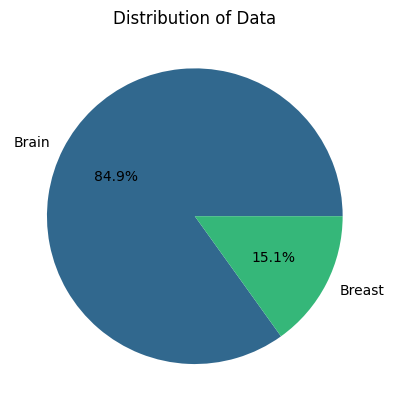

In [ ]:
plt.pie([len(train_labels), len(test_labels)], labels=['Brain', 'Breast'], autopct='%1.1f%%')
plt.title('Distribution of Data')
plt.show()

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Visualize Random Samples
    </span>
</div>


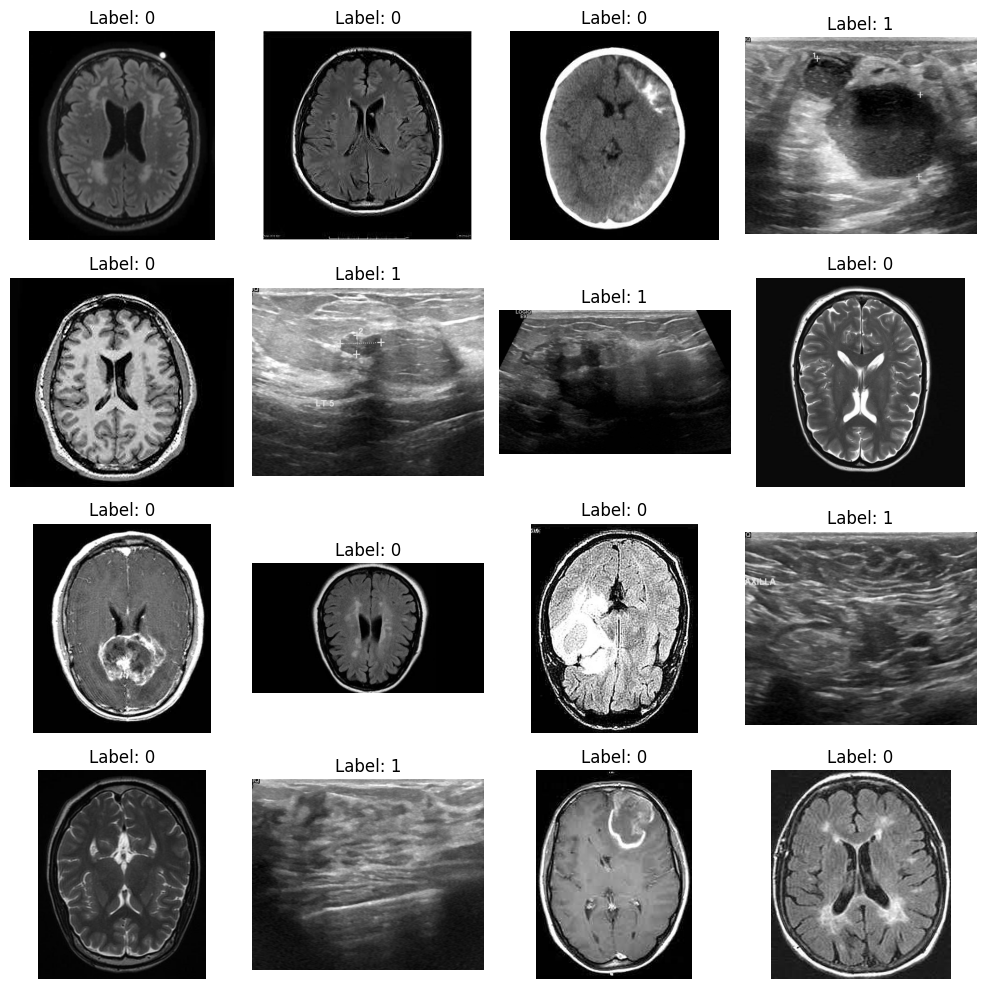

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img_path = np.random.choice(train_paths)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {train_labels[train_paths.index(img_path)]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         CNN
    </span>
</div>


In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=10,
                    callbacks=[early_stopping])


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.9268 - loss: 2.5013 - val_accuracy: 0.3813 - val_loss: 23.9304
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.9987 - loss: 0.1474 - val_accuracy: 0.3311 - val_loss: 82.3084
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9926 - loss: 0.3142 - val_accuracy: 0.3311 - val_loss: 190.6823
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.9938 - loss: 0.3169 - val_accuracy: 0.3712 - val_loss: 66.9221
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9985 - loss: 0.0721 - val_accuracy: 0.9599 - val_loss: 1.6551
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.9985 - loss: 0.1928 - val_accuracy: 0.8796 - val_loss: 3.5774
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9565 - val_loss: 1.8262
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 1.0000 - loss: 1.2634e-16 - val_accuracy: 0

<div style="
    background-color: #393E46;
    border-radius:  12px 12px;
    text-align: center;
    padding: 15px;
    margin: 10px 0;
">
    <span style="
        font-family: 'Comic Sans MS', 'Comic Neue', cursive;
        font-size: 28px;
        font-weight: bold;
        padding: 5px 15px;
        border-radius: 5px;
        color: #fff;
    ">
         Evaluation
    </span>
</div>


Text(0.5, 1.0, 'Training & Validation Loss')

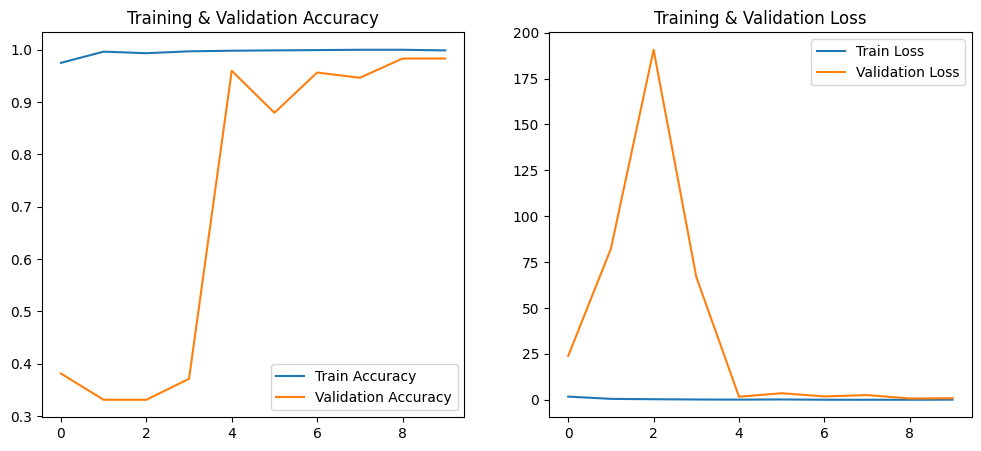

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

In [ ]:
predictions = model.predict(test_ds)
predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [7.0159927e-06],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.000000

In [ ]:
predictions = [1 if p > 0.5 else 0 for p in predictions]

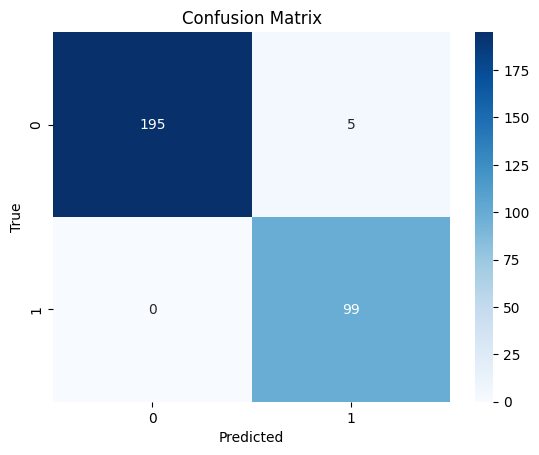

In [ ]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

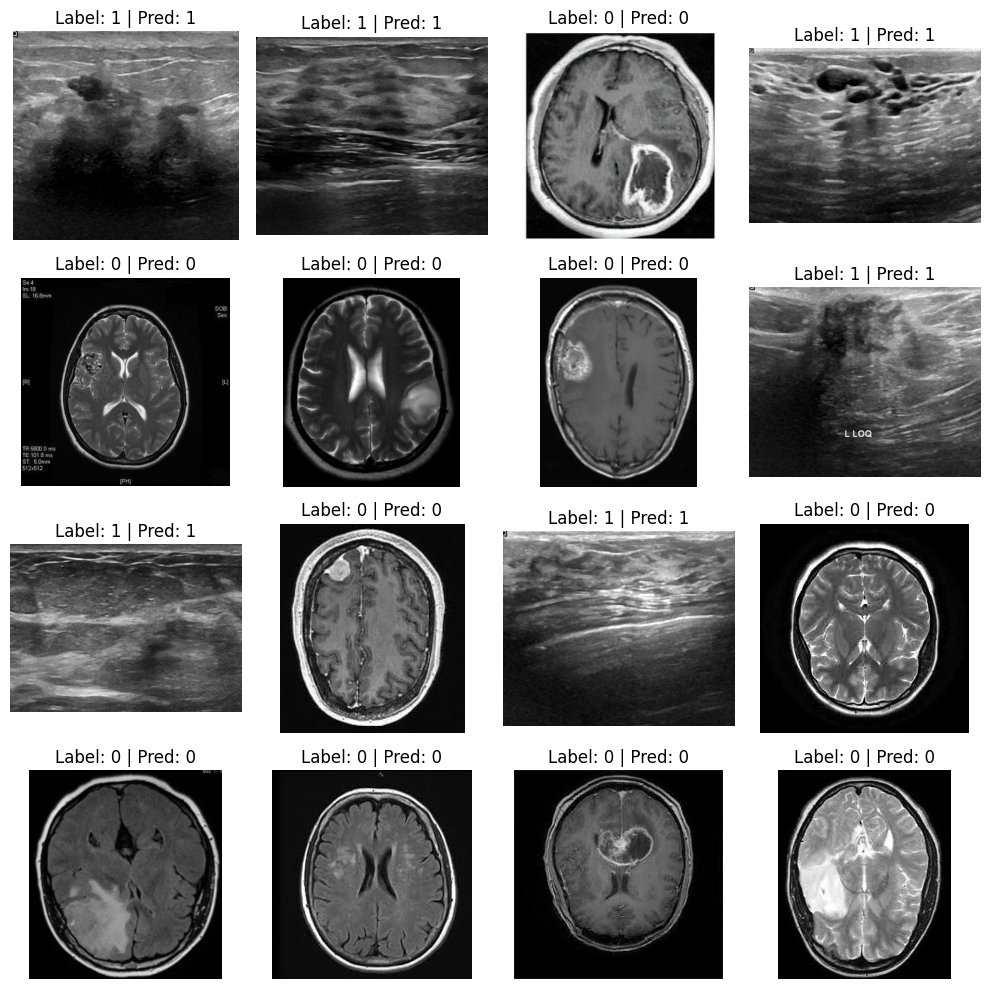

In [ ]:
# plot some random pred
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img_path = np.random.choice(test_paths)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {test_labels[test_paths.index(img_path)]} | Pred: {predictions[test_paths.index(img_path)]}")
    ax.axis('off')
plt.tight_layout()